Emotion detection deep learning model from images using Transfer Learning
---

---

link: https://www.kaggle.com/code/odins0n/emotion-detection

dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

DL model simulator: https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.92535&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

---

This code implements and train a deep learning model capable of analyzing a given image and recognize the emotion the person is expressing to then return the corresponding emoji that mirrors said emotion. For this particular implementation transfer learning is included for higher accuracy

---
Machine Learning

By: Sebastian Russo


---

Imports
---

In [ ]:
#Necessary libraries
#Logging
import logging

#Dataset analysis
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt   
%matplotlib inline
import seaborn as sns 
import plotly.express as pxt 

#Pre-Pre-processing image visualization
from PIL import Image             

#Deep Learning model itself
import tensorflow as tf           #Open source library for AI, ML and DL
from tensorflow import keras      #Integrated tensorflow API to implement high-level neural networks
from itertools import cycle       #Import cycle function from itertools

#Performance metrics to analyze model's performance
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve,average_precision_score

---

Hyper-parameters and global variables
---

In [ ]:
#General variables
#Directory paths from extracted zip (train data and test data)
train_directory = "../dataset/train"
test_directory = "../dataset/test"
model_name = "emotion_detection_from_image_transfer_learning.h5" #Either save in .h5 or native .keras

#Fixed images measurements
img_height = 48
img_width = 48

#Number of samples to be processed before the model is updated
batch_size = 64

#Fixed seed value for random number generators to ensure reproducibility
fixed_seed = 12

#Number of complete passes through the training dataset (may change)
epochs = 30 #Recommended 
#Number of epochs to run for fine-tuning after initial training
fine_tuning_epochs = 20 #Recommended

#Hyperparameter to control the change in the model based on estimated error each time model weights change
learn_r = 0.01
#Number of epochs with no improvements before model is forced to stop
early_stop_crit=3

#Image related variables
#7 classes for seven emotions and of course 2 arrays with the lables and actual emojis
class_labels  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
class_label_emojis = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]
class_nums = len(class_labels)

---

Data visualization
---

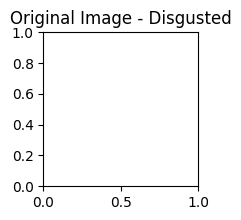

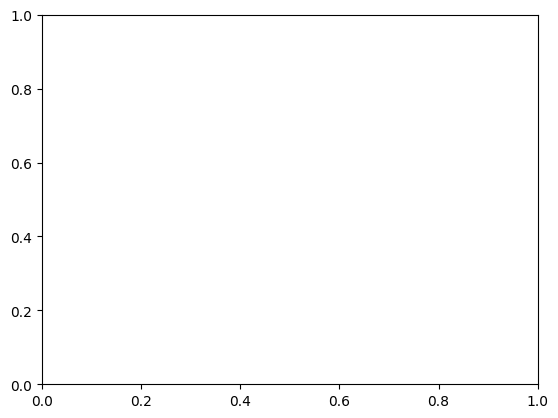

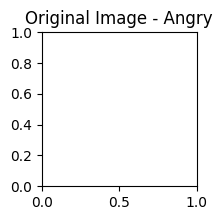

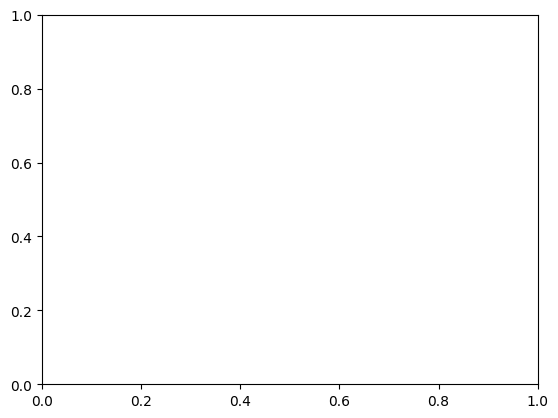

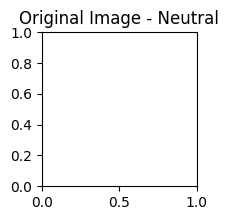

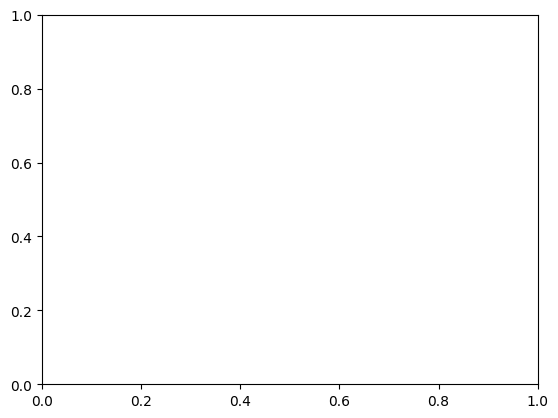

In [3]:
#Path to a particular image file
img_1_path = "../dataset/train/disgusted/im0.png"
img_2_path = "../dataset/train/angry/im0.png"
img_3_path = "../dataset/train/neutral/im0.png"

#Open the image files
img_1 = Image.open(img_1_path)
img_2 = Image.open(img_2_path)
img_3 = Image.open(img_3_path)

#Display the first image of disgusted
plt.figure(figsize=(2, 2))
plt.title('Original Image - Disgusted')
plt.show(img_1)
plt.axis('on')
plt.show()

#Display the first image of angry
plt.figure(figsize=(2, 2))
plt.title('Original Image - Angry')
plt.show(img_2)
plt.axis('on')
plt.show()

#Display the first image of neutral
plt.figure(figsize=(2, 2))
plt.title('Original Image - Neutral')
plt.show(img_3)
plt.axis('on')
plt.show()

---

Data pre-processing
---

In [4]:
#To preprocesses input image data so it is suitable for DenseNet
#neural models (scale and normalize pixels)
pre_process_method = tf.keras.applications.densenet.preprocess_input #better for large datasets

#--------------------------------------------------------------------------------------------------------
#Image data generator to augment and preprocess each data point (image) for training
#It actually transforms given .png
train_data = keras.preprocessing.image.ImageDataGenerator (
    horizontal_flip=True,     #Randomly flips the images horizontally

    width_shift_range=0.1,    #Shift image 10% of its horizontally at random
    height_shift_range=0.05,  #Shift image 5% of its vertically at random
    rescale = 1./255,         #Rescale pixels to range [0,1] and divide it in 255 pieces

    validation_split = 0.2,   #Split data 80-20% training-validation

    preprocessing_function=pre_process_method #Use preprocess function for DenseNet, now pixels are [-1,1]
)

#Image data generator to preprocess each data point (image) for testing
#It actually transforms given .png
test_data = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,           #Rescale pixels to range [0,1] and divide it in 255 pieces

    validation_split = 0.2,     #Split data 80-20% training-testing

    preprocessing_function=pre_process_method #Use preprocess function for DenseNet, now pixels are [-1,1]
)

#--------------------------------------------------------------------------------------------------------
#Train data generator to load and preprocess image, applies preprocess, yield batches of images and their labels for training
#Xtrain (images) and Ytrain (their labels)
train_generator = train_data.flow_from_directory(#Go through each file in the specified directory
    directory = train_directory,             #Specified directory, /content/train

    target_size = (img_height,img_width),     #Specify measurements of images
    batch_size = batch_size,                 #Provide number of images per batch (64)
    shuffle  = True,                        #Modify the order of the data points
    color_mode = "rgb",                     #Load images in RGB format

    class_mode = "categorical",             #Since we have 7 classes, specify as categorical (one-hot encode)

    subset = "training",                    #Specify as training subset (80%)
    seed = fixed_seed                        #Use fixed seed for random operations, shuffle and split (12)
)

#Train data generator to load and preprocess image applies preprocess, yield batches of imags and their labels for validation
#Xvalidation (images) and Yvalidation (their labels)
train_validation_generator = train_data.flow_from_directory(
    directory = train_directory,           #Specified directory, /content/train

    target_size = (img_height ,img_width),  #Specify measurements of images
    batch_size = batch_size,               #Provide number of images per batch (64)
    shuffle  = True,                      #Modify the order of the data points
    color_mode = "rgb",                   #Load images in RGB format

    class_mode = "categorical",           #Since we have 7 classes, specify as categorical (one-hot encode)

    subset = 'validation',                #Specify as training subset (20%)
    seed = fixed_seed                      #Use fixed seed for random operations, shuffle and split (12)
)

#Test data generator to load and preprocess image applies preprocess, yield batches of imags and their labels for testing
#Xtest (images) and Ytest (their labels)
test_generator = test_data.flow_from_directory(
    directory = test_directory,            #Specified directory, /content/test

    target_size = (img_height,img_width),  #Specify measurements of images
    batch_size = batch_size,               #Provide number of images per batch (64)
    shuffle  = False,                     #Don't modify the order of the data points, keep it constant
    color_mode = "rgb",                   #Load images in RGB format

    class_mode = "categorical",           #Since we have 7 classes, specify as categorical (one-hot encode)
    seed = fixed_seed                      #Use fixed seed for random operations, split (12)
)

#After this cell is executed, .png files will be converted into NumPy arrays in batches of 64

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
#train_generator, train_validation_generator and
#test_generator are initialized data generators

#Get the next batch of images and labels from the generator
train_images, train_labels = next(train_generator)

valid_images, valid_labels = next(train_validation_generator)

test_images, test_labels = next(test_generator)

#--------------------------------------------------------------------------------------------------------
#Access a specific data point within the batch
any_img = train_images[0]
any_img_label = train_labels[0]

any_valid_image = valid_images[0]
any_valid_label = valid_labels[0]

any_test_images = test_images[0]
any_test_labels = test_labels[0]

#--------------------------------------------------------------------------------------------------------
#Log examples
logging.info("Specific Image Shape:", any_img.shape)
logging.info("Specific Label:", any_img_label)
logging.info("Specific Image (numpy array):",any_img)
logging.info("")

logging.info("Validation Image Shape:", any_valid_image.shape)
logging.info("Validation Label:", any_valid_label)
logging.info("Validation Image (numpy array):", any_valid_image)
logging.info("")

logging.info("Test Image Shape:", any_test_images.shape)
logging.info("Test Label:", any_test_labels)
logging.info("Test Image (numpy array):", any_test_images)

---

DenseNet169 CNN architecture
---

In [6]:
#Functions to implement the DenseNet DL model

#To extract features from input (pre-processed) images using pre-trained convolutional
#layers to capture hierarchical features of images
def feature_extractor(inputs):

    feature_extractor = tf.keras.applications.DenseNet169(
                        input_shape=(img_height,img_width, 3),   #Specify the expected shape of inputs
                        include_top=False,                     #Don't include fully connected layers
                        weights="imagenet")(inputs)            #Initialize model with pretrained weights

    return feature_extractor

#To take extracted features by DenseNet169 and perform final classification
def DL_model_5_layers (inputs):
    #1st layer, reduce parameters and prevent overfitting
    DRE = tf.keras.layers.GlobalAveragePooling2D()(inputs)

    #2nd layer: Dense layer with dropout for regularization
    DRE = tf.keras.layers.Dense(
        256,                                                      #number of neurons
        activation="relu",                                        #Rectified Linear Unit for hidden layers
        kernel_regularizer = tf.keras.regularizers.l2(0.01))(DRE) #To penalize large weights and prevent overfitting
    DRE = tf.keras.layers.Dropout(0.3)(DRE)  #Regularization technique to drop 30% of neurons at random

    #3rd layer: Dense layer with dropout for regularization
    DRE = tf.keras.layers.Dense(
        1024,                                                     #number of neurons
        activation="relu",                                        #Rectified Linear Unit for hidden layers
        kernel_regularizer = tf.keras.regularizers.l2(0.01))(DRE) #To penalize large weights and prevent overfitting
    DRE = tf.keras.layers.Dropout(0.5)(DRE) #Regularization technique to drop 50% of neurons at random

    #4th layer: Dense layer with dropout for regularization
    DRE = tf.keras.layers.Dense(
        512,                                                      #number of neurons
        activation="relu",                                        #Rectified Linear Unit for hidden layers
        kernel_regularizer = tf.keras.regularizers.l2(0.01))(DRE) #To penalize large weights and prevent overfitting
    DRE = tf.keras.layers.Dropout(0.5)(DRE) #Regularization technique to drop 50% of neurons at random

    #5th layer, initialize dense (fully connected) layer in TensorFlow/Keras
    DRE = tf.keras.layers.Dense(
        7,                              #number of neurons equal to number of classes (7), One vs ALL
        activation="softmax",           #Use Softmax to scale each class into probabilities
        name="classification")(DRE)

    return DRE

#--------------------------------------------------------------------------------------------------------
#Put together the feature extraction function and DL 5-layered model
def final_DL_model(inputs):
    dsnt_feat_extractor = feature_extractor(inputs)      #Extract features from input .pngs
    classification_output = DL_model_5_layers(dsnt_feat_extractor) #Use extracted features as input to classify

    return classification_output

#Compile the model with specified optimizer, loss function, and metrics
def dl_model_compiler():

    inputs = tf.keras.layers.Input(     #Expected input shape
        shape=(img_height ,img_width,3)
    )

    classification_output = final_DL_model(inputs) #Use the final model for Deep Learning
    model = tf.keras.Model(
        inputs=inputs,                   #Input layer
        outputs = classification_output          #Output layer
    )

    model.compile(
        #optimizer="adam",                       #Optional optimizer
        optimizer=tf.keras.optimizers.SGD(0.1),  #Selected optimizer
        #loss="sparse_categorical_crossentropy", #Optional loss function
        loss='categorical_crossentropy',         #Selected loss function
        metrics = ['accuracy']                    #selected metrics to evaluate
    )

    return model

---

Train model with freezed layers, then unfreeze them
---

In [7]:
#model_to_train overview
model_to_train = dl_model_compiler()

#Freezing the feature extraction layers
model_to_train.layers[1].trainable = False

model_to_train.summary()

#Ensure data is correctly preprocessed to train model with freezed layers
logging.info(f"Training Generator: {train_generator.class_indices}")
logging.info(f"Training Validation Generator: {train_validation_generator.class_indices}")

logging.info(f"Batch size: {batch_size}")

images, labels = next(train_generator)
logging.info(f"Batch shape: {images.shape}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1, 1, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,860,679 (52.87 MB)

 Trainable params: 1,217,799 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [8]:
#Train model_to_train with freezed layers (Transfer learning)
#Freeze the feature extraction layers, it is already frozen but just to be sure
model_to_train.layers[1].trainable = False

#Define Early Stopping callback to monitor validation loss (avoid overfitting)
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         #Monitor validation loss for early stopping
    patience=early_stop_crit,   #Num of epochs with no improvement before stopping
    verbose= 1,                 #Verbosity mode. 1 = progress bar line per epoch
    restore_best_weights=True   #Restore model_to_train weights from the epoch
)

#Train the model_to_train with training generator and validate with validation generator
history_1 = model_to_train.fit(
    x = train_generator,                         #Training data generator
    epochs = epochs,                             #Number of epochs to train the model_to_train
    validation_data = train_validation_generator, #Validation data generator
    callbacks= [early_stop_callback]              #List of callbacks to apply
)

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 135s 334ms/step - accuracy: 0.2277 - loss: 13.0918 - val_accuracy: 0.2513 - val_loss: 5.4655
Restoring model weights from the end of the best epoch: 1.


In [9]:
#Un-Freeze the feature extraction layers for fine-tuning (Transfer learning)
model_to_train.layers[1].trainable = True

#Compile the model_to_train with different parameters
model_to_train.compile(
    optimizer=tf.keras.optimizers.SGD(0.001),  #Selected optimizer (lower LR)
    loss='categorical_crossentropy',           #Selected loss function
    metrics=['accuracy']                       #Selected metrics to evaluate
)

#Fine-tune model_to_train with training generator and validate with validation generator
history_2 = model_to_train.fit(
    x=train_generator,                          #Training data generator
    epochs=fine_tuning_epochs,                   #Number of epochs for fine-tuning
    validation_data=train_validation_generator   #Validation data generator
)

359/359 ━━━━━━━━━━━━━━━━━━━━ 284s 703ms/step - accuracy: 0.2539 - loss: 5.4544 - val_accuracy: 0.2513 - val_loss: 5.6065


In [10]:
#Convert the history object into a DataFrame
history_1_df = pd.DataFrame(history_1.history)

#Convert the history of fine-tuning to a DataFrame
history_2_df = pd.DataFrame(history_2.history)

#Concatenate the history DataFrame with the new history DataFrame
final_history = pd.concat([history_1_df, history_2_df], ignore_index=True)

#Now we can evaluate the model's performance

---

Model evaluation
---

In [11]:
#Create a line plot to visualize accuracy and validation accuracy over epochs
model_plot = pxt.line(
    data_frame=final_history,             #Use the history DataFrame for plotting
    y=["accuracy", "val_accuracy"],       #Plot both training and validation accuracy
    markers=True                          #Show markers on the plot
)

#Update the x-axis title to indicate the number of epochs
model_plot.update_xaxes(title="# of Epochs")
#Update the y-axis title to indicate the metric (Accuracy)
model_plot.update_yaxes(title="Accuracy")

#Update the layout of the plot to show the legend, set the title, and adjust its position
model_plot.update_layout(
    showlegend=True,                            #Show the legend on the plot
    title={
        'text': 'Accuracy vs # of Epochs', #Title of the plot
        'y': 0.94,                              #Vertical position of the title
        'x': 0.5,                               #Horizontal position of the title
        'xanchor': 'center',                    #Anchor point for horizontal position
        'yanchor': 'top'                        #Anchor point for vertical position
    }
)

#Display the plot
model_plot.show()

#--------------------------------------------------------------------------------------------------------
#Create a line plot to visualize loss and validation loss over epochs
model_plot = pxt.line(
    data_frame=final_history,   #Use the history DataFrame for plotting
    y=["loss", "val_loss"],    #Plot both training and validation loss
    markers=True               #Show markers on the plot
)

#Update the x-axis title to indicate the number of epochs
model_plot.update_xaxes(title="# of Epochs")
#Update the y-axis title to indicate the metric (Loss)
model_plot.update_yaxes(title="Loss")

#Update the layout of the plot to show the legend, set the title, and adjust its position
model_plot.update_layout(
    showlegend=True,                   #Show the legend on the plot
    title={
        'text': 'Loss vs # of Epochs',  #Title of the plot
        'y': 0.94,                           #Vertical position of the title
        'x': 0.5,                            #Horizontal position of the title
        'xanchor': 'center',                 #Anchor point for horizontal position
        'yanchor': 'top'                     #Anchor point for vertical position
    }
)

#Display the plot
model_plot.show()

In [12]:
#Evaluate the model_to_train on the test data generator
model_to_train.evaluate(test_generator)

#Make predictions on the test data generator
predictions = model_to_train.predict(test_generator)

#Extract the predicted labels by taking the index of the maximum probability in each prediction
predict_Y = np.argmax(predictions, axis=1)

#Extract the true labels from the test data generator
Y_test = np.array(test_generator.labels)

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



113/113 ━━━━━━━━━━━━━━━━━━━━ 73s 647ms/step - accuracy: 0.2225 - loss: 5.8714
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step


Simple Confusion Matrix:
[[   0    0    0  958    0    0    0]
 [   0    0    0  111    0    0    0]
 [   0    0    0 1024    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0 1233    0    0    0]
 [   0    0    0 1247    0    0    0]
 [   0    0    0  831    0    0    0]]

Heatmap Confusion Matrix:


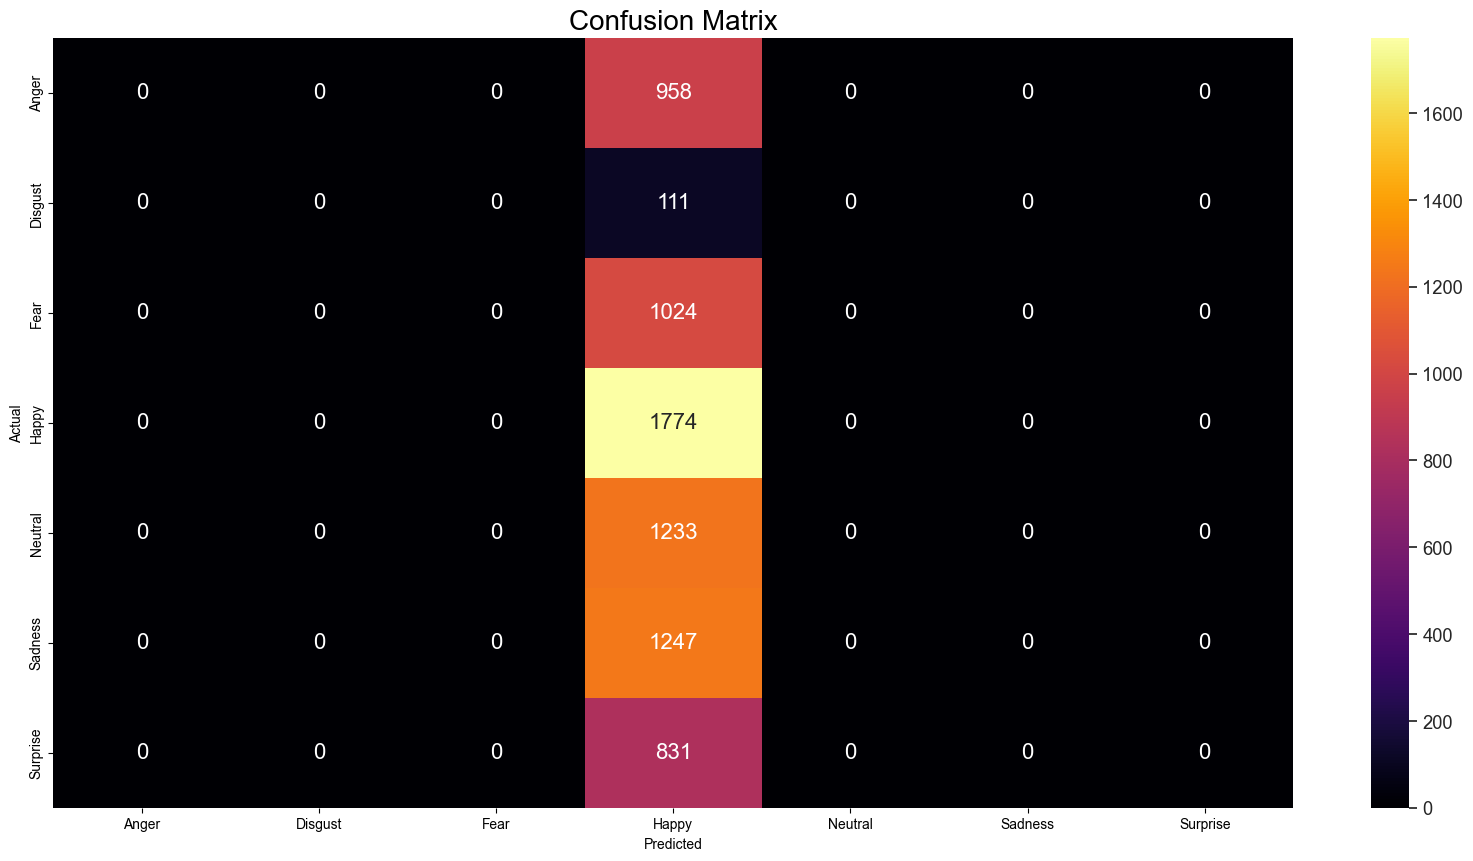

In [13]:
#Compute the confusion matrix
confusion_matrix_data = confusion_matrix(Y_test, predict_Y)

#Print confusion matrix
print("Simple Confusion Matrix:")
print(confusion_matrix_data)
print("")

#Create a pandas DataFrame for the confusion matrix with class labels as columns and indices
print("Heatmap Confusion Matrix:")
confusion_matrix = pd.DataFrame(
    confusion_matrix_data,              #Confusion matrix data
    columns=class_labels,      #Column labels uses class labels
    index=class_labels         #Row labels uses class labels
)

#Set the index name for the true labels and column names for the predicted labels
confusion_matrix.index.name = 'Actual'
confusion_matrix.columns.name = 'Predicted'

#Set the size of the figure for the heatmap
plt.figure(figsize=(20, 10))

#Set the title and font size for the confusion matrix plot
plt.title('Confusion Matrix', fontsize=20)
#Set the font scale for the heatmap
sns.set(font_scale=1.2)

#Create a heatmap using seaborn with the confusion matrix data
model_heat = sns.heatmap(
    confusion_matrix,                 #Matrix data to plot
    cbar=True,               #Enable the color bar
    cmap="inferno",          #Blues colormap for the heatmap
    annot=True,              #Annotate each cell with the numerical value
    annot_kws={"size": 16},  #Set the text size
    fmt='g'                  #Format test as general numbers (INT)
)

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step


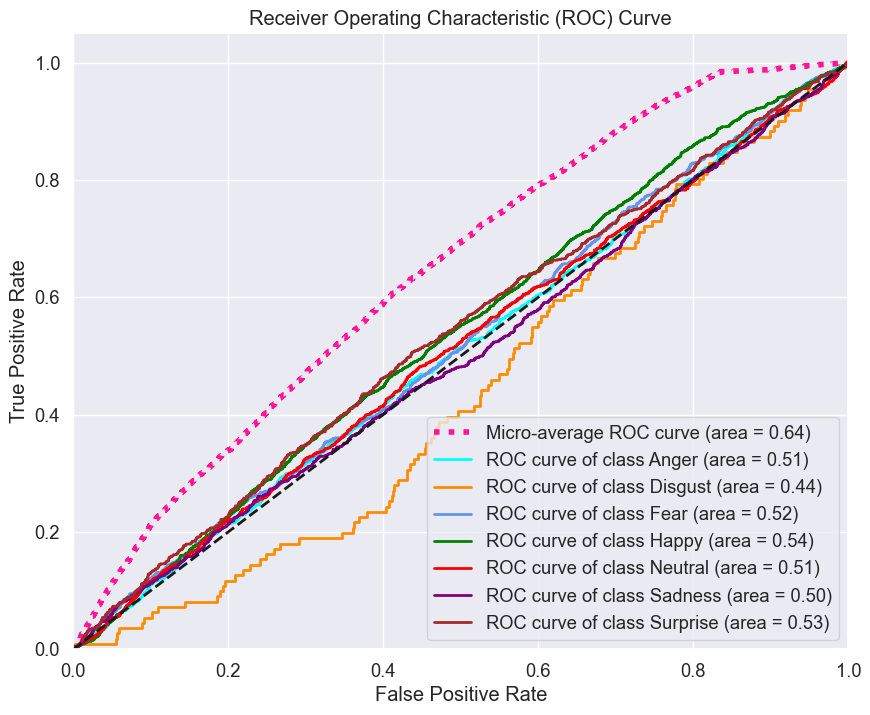

In [14]:
#Predict probabilities for the test data
Y_predict_probabilities = model_to_train.predict(test_generator, verbose=1)

#Convert the labels to one-hot encoding
Y_test_one_hot_enc = tf.keras.utils.to_categorical(Y_test, num_classes=len(class_labels))

#Initialize dictionaries to store fpr, tpr, and roc_auc for each class
fpr = {}
tpr = {}
roc_auc = {}

#Compute ROC metrics for each class
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot_enc[:, i], Y_predict_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_one_hot_enc.ravel(), Y_predict_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#--------------------------------------------------------------------------------------------------------

#Plot ROC curve for each class and micro-average
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'
        ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

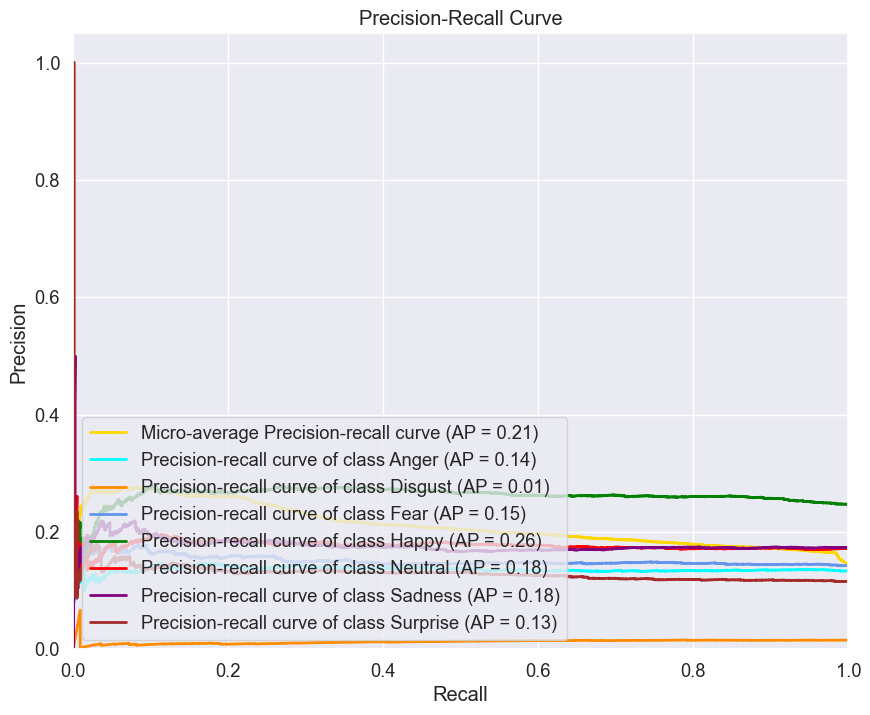

In [15]:
#Initialize dictionaries to store precision, recall, and average precision
precision = {}
recall = {}
average_precision = {}

#Compute Precision-Recall metrics for each class
for i in range(len(class_labels)):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_one_hot_enc[:, i], Y_predict_probabilities[:, i])
    average_precision[i] = average_precision_score(Y_test_one_hot_enc[:, i], Y_predict_probabilities[:, i])

#Compute micro-average Precision-Recall curve and PR area
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test_one_hot_enc.ravel(), Y_predict_probabilities.ravel())
average_precision["micro"] = average_precision_score(Y_test_one_hot_enc, Y_predict_probabilities, average="micro")

#--------------------------------------------------------------------------------------------------------

#Plot Precision-Recall curve for each class and micro-average
plt.figure(figsize=(10, 8))
plt.plot(recall["micro"], precision["micro"], color='gold', lw=2,
        label='Micro-average Precision-recall curve (AP = {0:0.2f})'
            ''.format(average_precision["micro"]))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
            label='Precision-recall curve of class {0} (AP = {1:0.2f})'
            ''.format(class_labels[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [16]:
#Generate and print the classification report
logging.info(classification_report(Y_test, predict_Y))

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



---

Save trained model
---

In [17]:
import os
# Create the directory using shell command, in case it does not exist
directory_name = "../trained_dl_models"
os.makedirs(directory_name, exist_ok=True)

# Define the model path
model_path = os.path.join(directory_name, model_name) 
# Save the model
model_to_train.save(model_path)
logging.info(f"Model saved to {model_path}")
